## Simulate two different systems with the same mean so that the 2 time series are similar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tqdm
import sympy as sp
from sympy import *
from scipy.optimize import fsolve
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# Import all the functions from the 'src' directory, we import all the functions from each module so we can use them straight away
from ssa_simulation import simulate_two_telegraph_model_systems
from ssa_analysis import *
from ssa_classification import *
from models.MLP import MLP
from utils.load_data import load_and_split_data
%load_ext autoreload
%autoreload 2

**The telegraph model:**

$$
G^{\star} \xrightleftharpoons[\sigma_{\text{u}}]{\sigma_{\text{b}}} G \xrightarrow{\rho} G + M, \quad M \xrightarrow{d} \emptyset
$$

**System 1:** Normal Condition (σ_u_normal = 9.0, σ_b_normal = 0.02)

**System 2:** Stressed Condition (σ_u_stress = 18.0, σ_b_stress = 0.01)

- Higher gene deactivation rate: genes encoding metabolic enzymes under stress do not stay active for long.
- Lower gene activation rate: stress often results in strong repression of transcription by repressors, which makes gene activation rarer.
This combination will lead to lower mRNA levels.

**Theoretical foundation:**

The equation for the mean mRNA levels at steady state, in terms of the system parameters, is:

$$ \mu = \frac{\sigma_b \rho}{d (\sigma_b + \sigma_u)} $$

The equation for the mRNA level variance at steady state, in terms of the system parameters, is: 

$$ \sigma ^2 = \frac{\sigma_b \rho}{d (\sigma_b + \sigma_u)} + \frac{\sigma_u \sigma_b}{({\sigma_u + \sigma_b})^2} \frac{\rho^2}{d(\sigma_u + \sigma_b + d)} $$



## Fixing mean

From these equations, we can fix the mean or variance to be the same by moving the terms around. Below is an example, to **fix the mean of the mRNA levels**. 

In [35]:
# Define symbols
rho, mu, sigma_sq, d, sigma_u, sigma_b = sp.symbols('rho mu sigma_sq d sigma_u sigma_b') # sigma_sq is variance
init_printing(use_unicode=True)
# define the variance and mean equations, these should be equations that are have all terms re-arranged to the LHS, and 0 on the RHS, i.e., for x = y, you are defining x - y (= 0)
mean_eq = mu - (
    sigma_b * rho / (d * (sigma_b + sigma_u))
                )

# Solve the equation for rho
solutions = solve(mean_eq, rho, dict= True) 

# Define system parameters
mu_target = 10.0  

# Define activation/deactivation rates and degradation rates for the conditions
parameters = {
    "stress": {"sigma_u": 18.0, "sigma_b": 0.01, "d": 1.0},
    "normal": {"sigma_u": 9.0, "sigma_b": 0.02, "d": 1.0}
}
# Store positive rho values for both conditions
rho_values = {}
for condition, param_set in parameters.items():
    for sol in solutions:
        rho_value = sol[rho].subs({
            sigma_u: param_set["sigma_u"], 
            sigma_b: param_set["sigma_b"], 
            d: param_set["d"], 
            mu: mu_target, 
        })
        
        # Store only positive solutions
        if rho_value > 0:
            rho_values[condition] = rho_value
            break  # Stop searching if positive solution is found

# Updated Parameter Sets using the calculated rho values
parameter_sets = [
    {"sigma_u": parameters["stress"]["sigma_u"], 
     "sigma_b": parameters["stress"]["sigma_b"], 
     "rho": rho_values["stress"], 
     "d": parameters["stress"]["d"], 
     "label": 0},
     
    {"sigma_u": parameters["normal"]["sigma_u"], 
     "sigma_b": parameters["normal"]["sigma_b"], 
     "rho": rho_values["normal"], 
     "d": parameters["normal"]["d"], 
     "label": 1}
]

# Set up simulation parameters 
# get the min degradation rate
min_d = min([param_set['d'] for param_set in parameter_sets])    
# get the time point after which the system reaches steady state 
steady_state_time = int(10 / min_d)

# !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
# 144 time points: to match experimental conditions, where typically a photo is taken every 5 min over 12 hours --> 144 time points
# extend time points to account for steady state
extended_time_points = np.arange(time_points[0], 
                                 len(time_points) + steady_state_time, 
                                 time_points[1] - time_points[0])

size = 200  # Reduce number of simulations per condition for efficiency

# Run the simulation function
df_results = simulate_two_telegraph_model_systems(parameter_sets, extended_time_points, size)

# Save dataset for ML classification
output_file = "data/mRNA_trajectories_mean_fixed.csv"
df_results.to_csv(output_file, index=False)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# report the mean and variance of the mRNA counts at steady state
report = statistical_report(parameter_sets, stress_trajectories, normal_trajectories)

Simulating Telegraph Model Systems:   0%|          | 0/2 [00:00<?, ?it/s]

Running simulations on 12 cores...
System 1 parameters: {'sigma_u': 18.0, 'sigma_b': 0.01, 'rho': 18010.0000000000, 'd': 1.0, 'label': 0}


Simulating Telegraph Model Systems:  50%|█████     | 1/2 [00:30<00:30, 30.23s/it]

Running simulations on 12 cores...
System 2 parameters: {'sigma_u': 9.0, 'sigma_b': 0.02, 'rho': 4510.00000000000, 'd': 1.0, 'label': 1}


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:55<00:00, 27.99s/it]


=== Statistical Report ===

📊 **Steady-State Statistics:**
  Stressed Condition (after 10.0 min):
    - Mean mRNA Count: 10.15
    - Variance: 10681.12

  Normal Condition (after 10.0 min):
    - Mean mRNA Count: 9.78
    - Variance: 4346.40


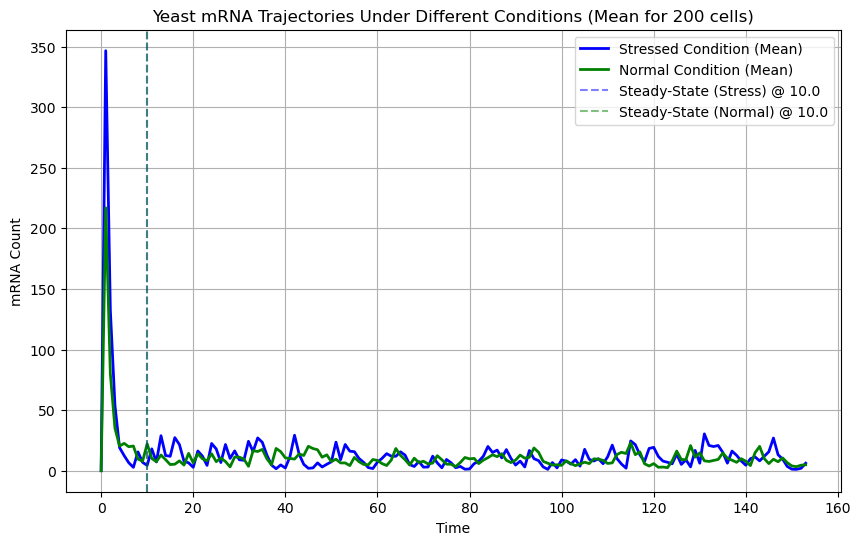

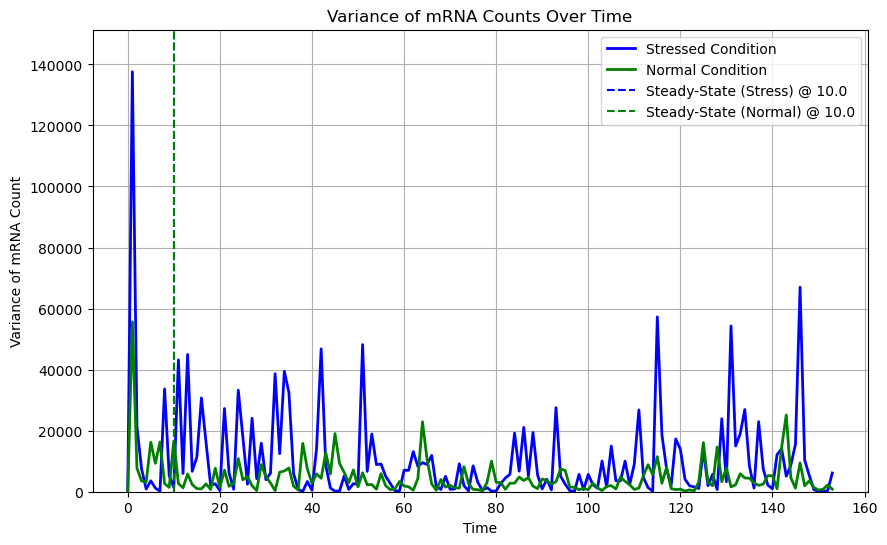


=== Variance at Steady State ===
  Stressed Condition (after 10.0 min): Mean = 10.69, Variance = 10028.48
  Normal Condition (after 10.0 min): Mean = 9.54, Variance = 4230.54


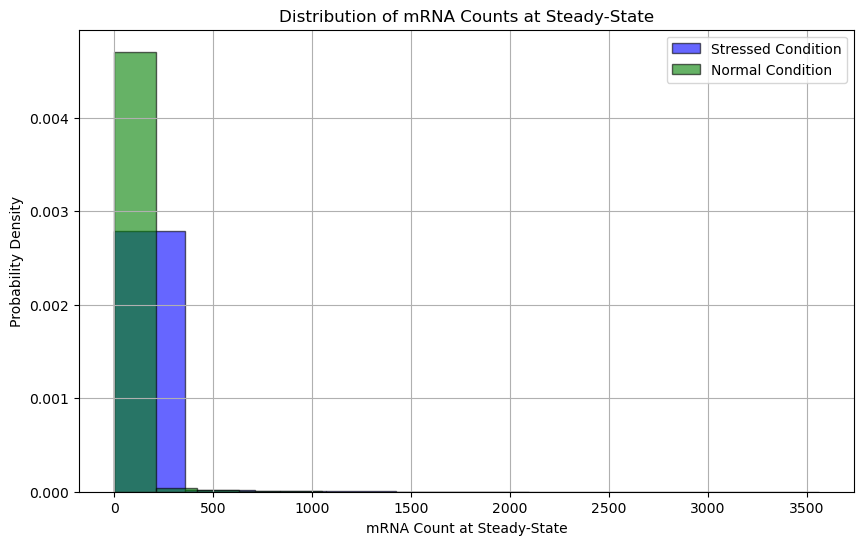

In [3]:
# Plots
plot_mRNA_trajectory(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_variance(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_dist(parameter_sets, stress_trajectories, normal_trajectories)

SVM to classify the two different environments, ideally we'd like to make things difficult for them to distinguish

=== SVM (RBF Kernel) Classification Accuracy: 0.60 ===
=== Random Forest Accuracy: 0.68 ===


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression Accuracy: 0.53 ===
=== Random Classifier Accuracy: 0.49 ===


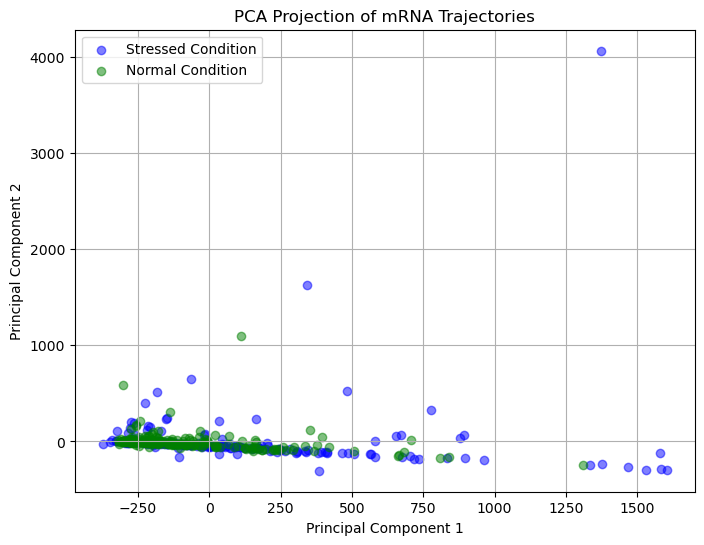

In [4]:
output_file = "data/mRNA_trajectories_mean_fixed.csv"
X_train, X_test, y_train, y_test = load_and_split_data(output_file)
svm_accuracy = svm_classifier(X_train, X_test, y_train, y_test)
rf_accuracy = random_forest_classifier(X_train, X_test, y_train, y_test)
log_reg_accuracy = logistic_regression_classifier(X_train, X_test, y_train, y_test)
random_accuracy = random_classifier(y_test)
pca_plot(output_file)

Autocorrelation

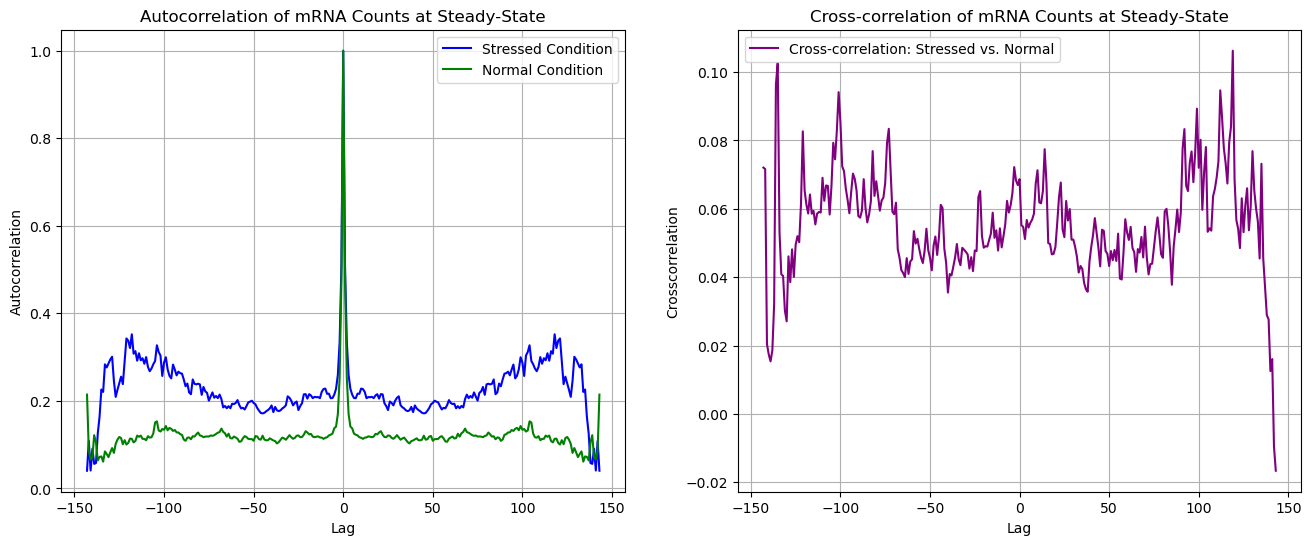

In [5]:
output_file = "data/mRNA_trajectories_mean_fixed.csv"
df_results = pd.read_csv(output_file)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

plot_autocrosscorr(parameter_sets, stress_trajectories, normal_trajectories)

## Fixing the Variance of mRNA counts
Fix the **variance** to be at a known value, using the equation 

$$ \sigma ^2 = \frac{\sigma_b \rho}{d (\sigma_b + \sigma_u)} + \frac{\sigma_u \sigma_b}{({\sigma_u + \sigma_b})^2} \frac{\rho^2}{d(\sigma_u + \sigma_b + d)} $$

Solving it for $ \rho $ using Mathematica, we get the following *positive* solution:

$$
\rho = -\frac{(\sigma_b + \sigma_u) \sqrt{ d + \sigma_b + \sigma_u} (\sqrt{\sigma_b} \sqrt{d + \sigma_b + \sigma_u} - \sqrt{\sigma_b (\sigma_b + \sigma_u) + d (\sigma_b + 4 \sigma ^2 \sigma_u)}
    )}{2 \sqrt{\sigma_b} \sigma_u}

$$

<!-- Initially, I used the sympy module from python to do the work for me, but I'm not convinced by its answers.

from sympy import symbols, Eq, solve

# Define variables
sigma_sq, sigma_b, sigma_u, rho, d = symbols('variance_target sigma_b sigma_u rho d')

# Define the given equation
eq = Eq(
    sigma_sq, 
    (sigma_b * rho) / (d * (sigma_b + sigma_u)) + 
    (sigma_u * sigma_b / (sigma_u + sigma_b)**2) * (rho**2 / (d * (sigma_u + sigma_b + d)))
)

# Solve for rho
rho_solution = solve(eq, rho)
rho_solution
 -->

### Variance of both systems to be the same

Simulating Telegraph Model Systems:   0%|          | 0/2 [00:00<?, ?it/s]

Running simulations on 12 cores...
System 1 parameters: {'sigma_u': 18.0, 'sigma_b': 0.01, 'rho': 1841.35262672509, 'd': 1.0, 'label': 0}


Simulating Telegraph Model Systems:  50%|█████     | 1/2 [00:03<00:03,  3.70s/it]

Running simulations on 12 cores...
System 2 parameters: {'sigma_u': 9.0, 'sigma_b': 0.02, 'rho': 667.980678288759, 'd': 1.0, 'label': 1}


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:07<00:00,  3.74s/it]



=== Statistical Report ===

📊 **Steady-State Statistics:**
  Stressed Condition (after 10.0 min):
    - Mean mRNA Count: 1.15
    - Variance: 122.78

  Normal Condition (after 10.0 min):
    - Mean mRNA Count: 1.45
    - Variance: 96.78
=== SVM (RBF Kernel) Classification Accuracy: 0.64 ===
=== Random Forest Accuracy: 0.66 ===


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression Accuracy: 0.60 ===
=== Random Classifier Accuracy: 0.49 ===


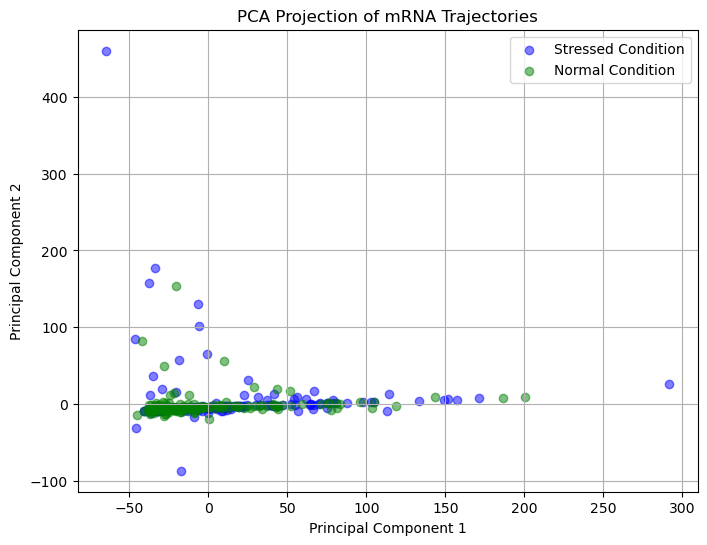

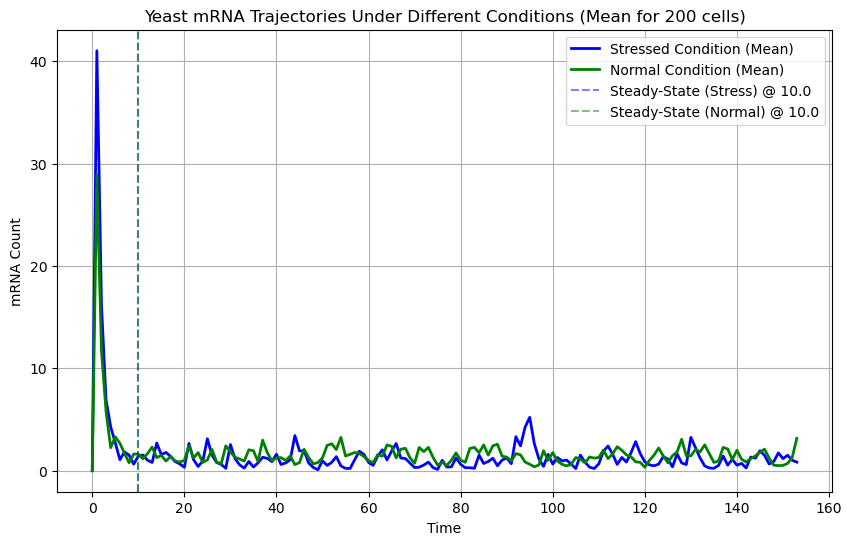

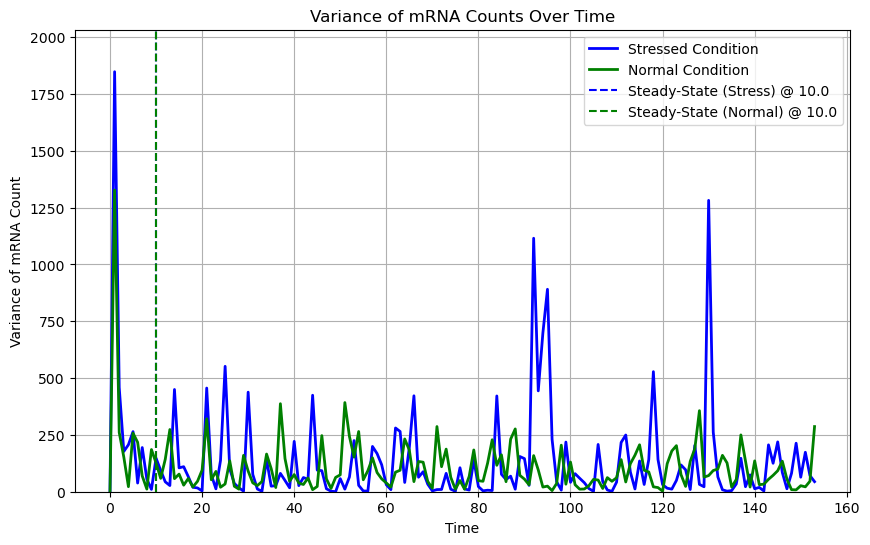


=== Variance at Steady State ===
  Stressed Condition (after 10.0 min): Mean = 1.15, Variance = 122.78
  Normal Condition (after 10.0 min): Mean = 1.45, Variance = 96.78


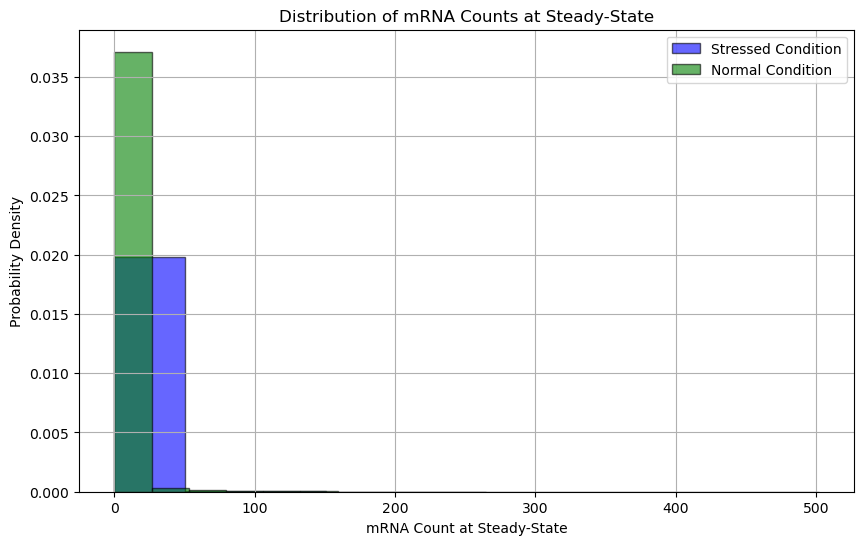

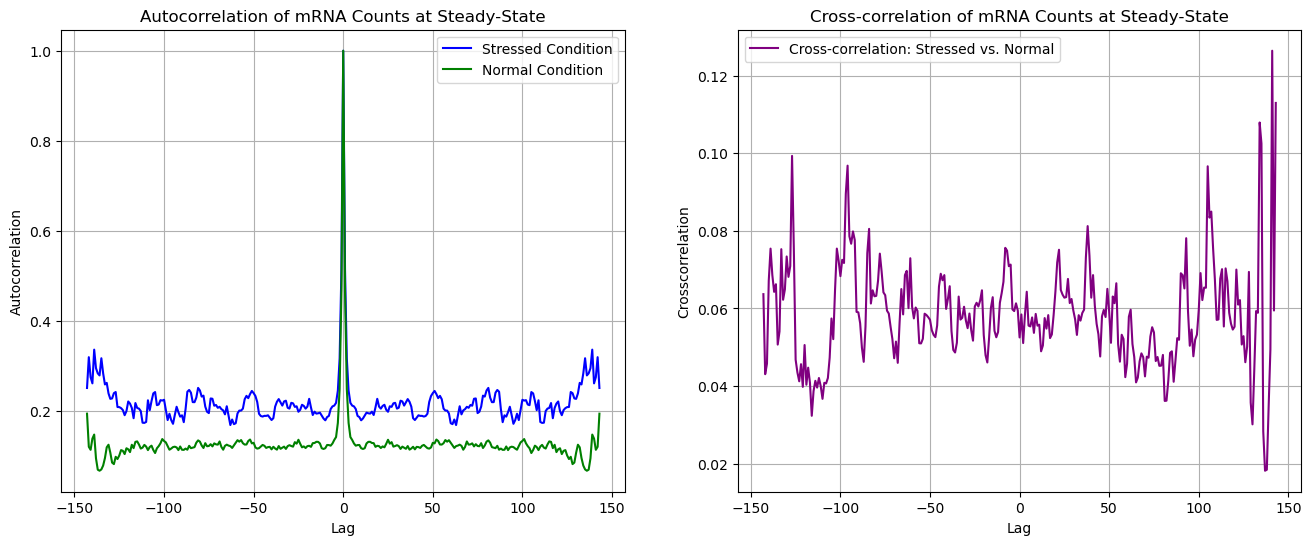

In [6]:
# Define symbols
rho, mu, sigma_sq, d, sigma_u, sigma_b = sp.symbols('rho mu sigma_sq d sigma_u sigma_b') # sigma_sq is variance
init_printing(use_unicode=True)
# define the variance and mean equations, these should be equations that are have all terms re-arranged to the LHS, and 0 on the RHS, i.e., for x = y, you are defining x - y (= 0)
variance_eq = sigma_sq - (
    sigma_b * rho / (d * (sigma_b + sigma_u)) + (sigma_u * sigma_b)*rho**2 / (d*(sigma_b + sigma_u + d)*(sigma_u + sigma_b)**2)
                          )  

# Solve the equation for rho, mu, and sigma_sq
solutions = solve(variance_eq, rho, dict= True) 

# target variance
variance_target = 100.0

# Define activation/deactivation rates and degradation rates for the conditions
parameters = {
    "stress": {"sigma_u": 18.0, "sigma_b": 0.01, "d": 1.0},
    "normal": {"sigma_u": 9.0, "sigma_b": 0.02, "d": 1.0}
}

# Store positive rho values for both conditions
rho_values = {}
for condition, param_set in parameters.items():
    for sol in solutions:
        rho_value = sol[rho].subs({
            sigma_u: param_set["sigma_u"], 
            sigma_b: param_set["sigma_b"], 
            d: param_set["d"], 
            sigma_sq: variance_target
        })
        
        # Store only positive solutions
        if rho_value > 0:
            rho_values[condition] = rho_value
            break  # Stop searching if positive solution is found

# Updated Parameter Sets using the calculated rho values
parameter_sets = [
    {"sigma_u": parameters["stress"]["sigma_u"], 
     "sigma_b": parameters["stress"]["sigma_b"], 
     "rho": rho_values["stress"], 
     "d": parameters["stress"]["d"], 
     "label": 0},
     
    {"sigma_u": parameters["normal"]["sigma_u"], 
     "sigma_b": parameters["normal"]["sigma_b"], 
     "rho": rho_values["normal"], 
     "d": parameters["normal"]["d"], 
     "label": 1}
]

# Set up simulation parameters 
# get the min degradation rate
min_d = min([param_set['d'] for param_set in parameter_sets])    
# get the time point after which the system reaches steady state 
steady_state_time = int(10 / min_d)

# !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
# 144 time points: to match experimental conditions, where typically a photo is taken every 5 min over 12 hours --> 144 time points
# extend time points to account for steady state
extended_time_points = np.arange(time_points[0], 
                                 len(time_points) + steady_state_time, 
                                 time_points[1] - time_points[0])

size = 200  # size of the simulation needs to be big enough for this particular system to reach steady state

# Run the simulation function
df_results = simulate_two_telegraph_model_systems(parameter_sets, extended_time_points, size)

# Save dataset for ML classification
output_file = f"data/mRNA_trajectories_variance_fixed_{variance_target}_{variance_target}.csv"
df_results.to_csv(output_file, index=False)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# report the mean and variance of the mRNA counts at steady state
report =  statistical_report(parameter_sets, stress_trajectories, normal_trajectories)
X_train, X_test, y_train, y_test = load_and_split_data(output_file)
svm_accuracy = svm_classifier(X_train, X_test, y_train, y_test)
rf_accuracy = random_forest_classifier(X_train, X_test, y_train, y_test)
log_reg_accuracy = logistic_regression_classifier(X_train, X_test, y_train, y_test)
random_accuracy = random_classifier(y_test)
pca_plot(output_file)

# Plots
plot_mRNA_trajectory(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_variance(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_dist(parameter_sets, stress_trajectories, normal_trajectories)
plot_autocrosscorr(parameter_sets, stress_trajectories, normal_trajectories)

Changing the variance ratio

Simulating Telegraph Model Systems:   0%|          | 0/2 [00:00<?, ?it/s]

Running simulations on 12 cores...
System 1 parameters: {'sigma_u': 18.0, 'sigma_b': 0.01, 'rho': 2018.00398888118, 'd': 1.0, 'label': 0}


Simulating Telegraph Model Systems:  50%|█████     | 1/2 [00:03<00:03,  3.73s/it]

Running simulations on 12 cores...
System 2 parameters: {'sigma_u': 9.0, 'sigma_b': 0.02, 'rho': 667.980678288759, 'd': 1.0, 'label': 1}


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:07<00:00,  3.77s/it]



=== Statistical Report ===

📊 **Steady-State Statistics:**
  Stressed Condition (after 10.0 min):
    - Mean mRNA Count: 1.12
    - Variance: 125.44

  Normal Condition (after 10.0 min):
    - Mean mRNA Count: 1.50
    - Variance: 99.66
=== SVM (RBF Kernel) Classification Accuracy: 0.56 ===
=== Random Forest Accuracy: 0.65 ===


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression Accuracy: 0.56 ===
=== Random Classifier Accuracy: 0.54 ===


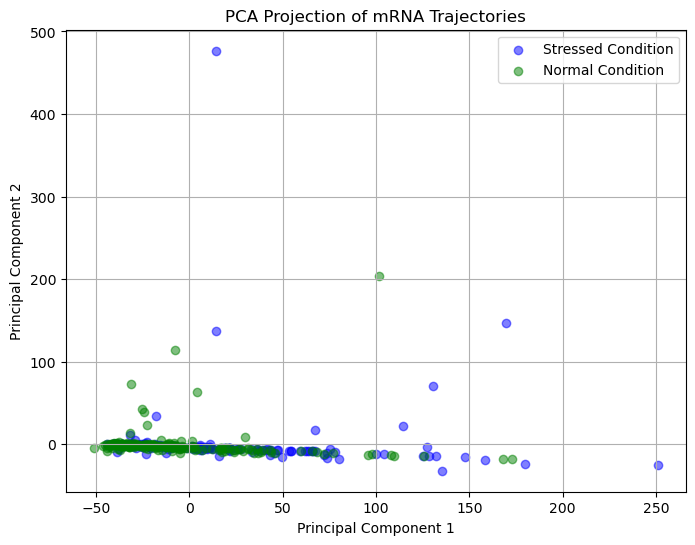

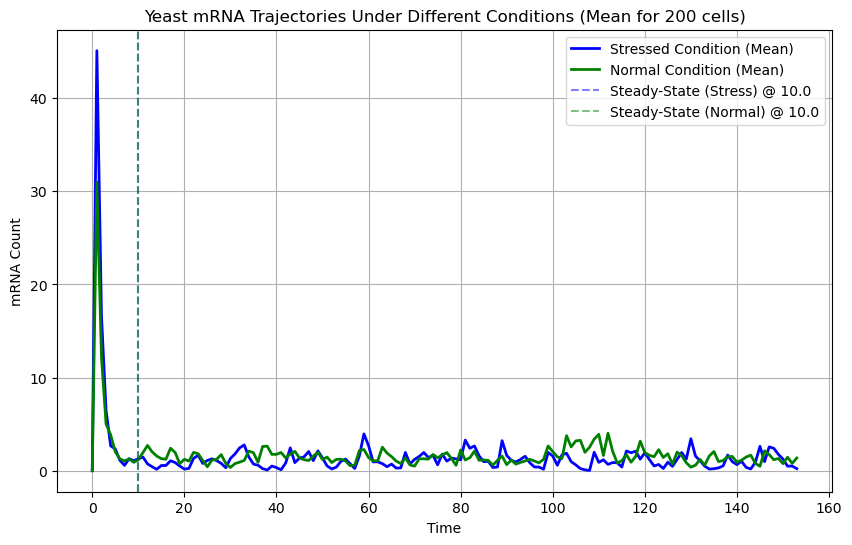

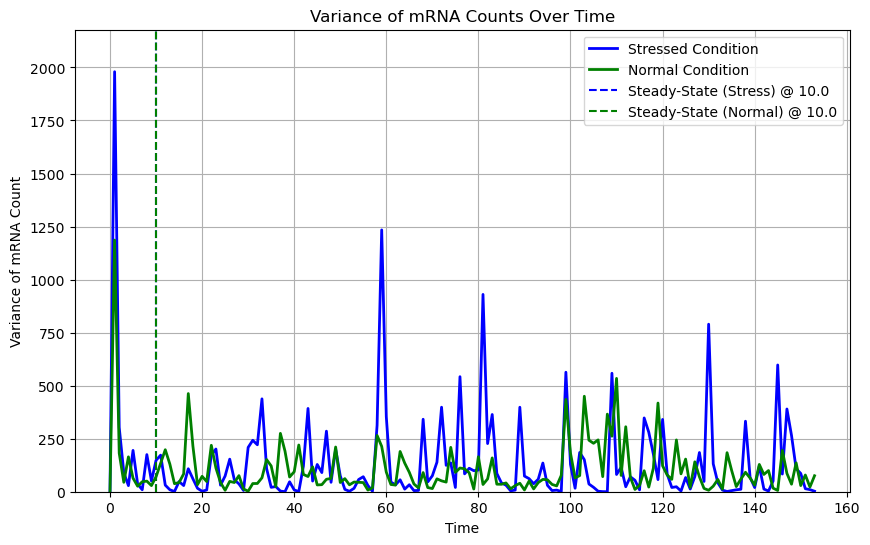


=== Variance at Steady State ===
  Stressed Condition (after 10.0 min): Mean = 1.12, Variance = 125.44
  Normal Condition (after 10.0 min): Mean = 1.50, Variance = 99.66


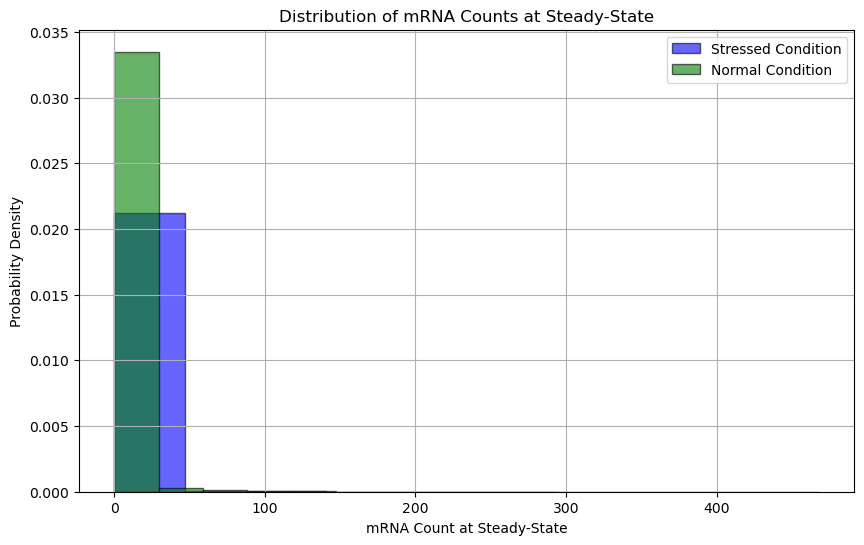

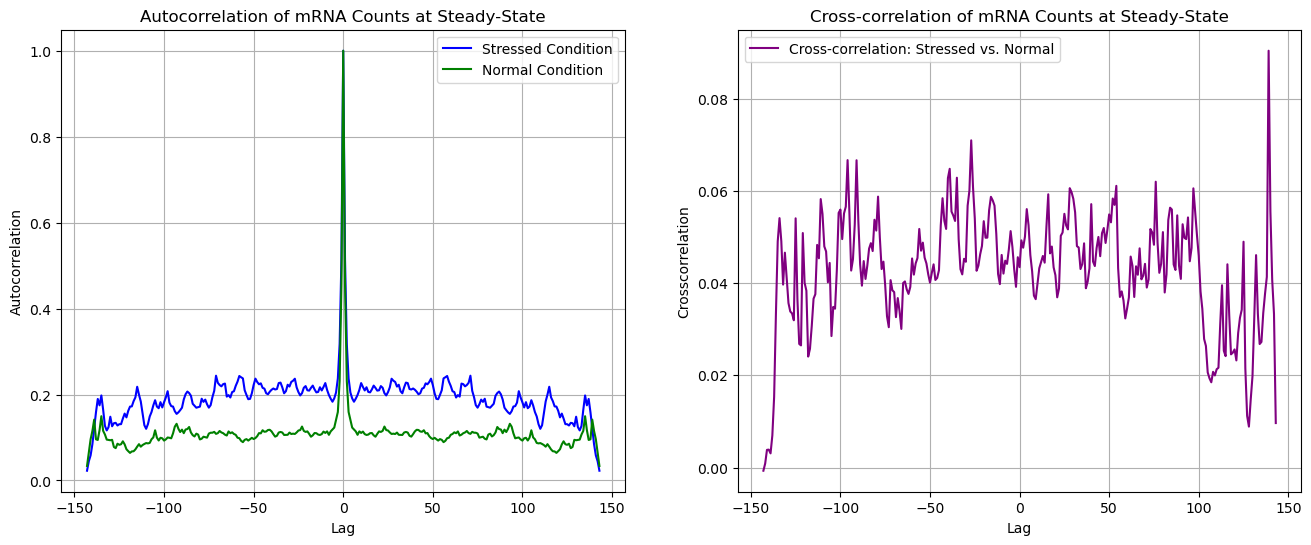

In [3]:
# Define symbols
rho, mu, sigma_sq, d, sigma_u, sigma_b = sp.symbols('rho mu sigma_sq d sigma_u sigma_b') # sigma_sq is variance
init_printing(use_unicode=True)
# define the variance and mean equations, these should be equations that are have all terms re-arranged to the LHS, and 0 on the RHS, i.e., for x = y, you are defining x - y (= 0)
variance_eq = sigma_sq - (
    sigma_b * rho / (d * (sigma_b + sigma_u)) + (sigma_u * sigma_b)*rho**2 / (d*(sigma_b + sigma_u + d)*(sigma_u + sigma_b)**2)
                          )  

# Solve the equation for rho, mu, and sigma_sq
solutions = solve(variance_eq, rho, dict= True) 

# target variance
variance_target_normal = 100.0
variance_target_stress = 120.0

# Define activation/deactivation rates and degradation rates for the conditions
parameters = {
    "stress": {"sigma_u": 18.0, "sigma_b": 0.01, "d": 1.0},
    "normal": {"sigma_u": 9.0, "sigma_b": 0.02, "d": 1.0}
}

# Store positive rho values for both conditions
rho_values = {}
for condition, param_set in parameters.items():
    for sol in solutions:

        if condition == "stress":
            variance_target = variance_target_stress
        else:
            variance_target = variance_target_normal

        rho_value = sol[rho].subs({
            sigma_u: param_set["sigma_u"], 
            sigma_b: param_set["sigma_b"], 
            d: param_set["d"], 
            sigma_sq: variance_target
        })
        
        # Store only positive solutions
        if rho_value > 0:
            rho_values[condition] = rho_value
            break  # Stop searching if positive solution is found

# Updated Parameter Sets using the calculated rho values
parameter_sets = [
    {"sigma_u": parameters["stress"]["sigma_u"], 
     "sigma_b": parameters["stress"]["sigma_b"], 
     "rho": rho_values["stress"], 
     "d": parameters["stress"]["d"], 
     "label": 0},
     
    {"sigma_u": parameters["normal"]["sigma_u"], 
     "sigma_b": parameters["normal"]["sigma_b"], 
     "rho": rho_values["normal"], 
     "d": parameters["normal"]["d"], 
     "label": 1}
]

# Set up simulation parameters 
# get the min degradation rate
min_d = min([param_set['d'] for param_set in parameter_sets])    
# get the time point after which the system reaches steady state 
steady_state_time = int(10 / min_d)

# !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
# 144 time points: to match experimental conditions, where typically a photo is taken every 5 min over 12 hours --> 144 time points
# extend time points to account for steady state
extended_time_points = np.arange(time_points[0], 
                                 len(time_points) + steady_state_time, 
                                 time_points[1] - time_points[0])

size = 200  # size of the simulation needs to be big enough for this particular system to reach steady state

# Run the simulation function
df_results = simulate_two_telegraph_model_systems(parameter_sets, extended_time_points, size)

# Save dataset for ML classification
output_file = f"data/mRNA_trajectories_variance_fixed_{variance_target}_{variance_target}.csv"
df_results.to_csv(output_file, index=False)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# report the mean and variance of the mRNA counts at steady state
report =  statistical_report(parameter_sets, stress_trajectories, normal_trajectories)
X_train, X_test, y_train, y_test = load_and_split_data(output_file)
svm_accuracy = svm_classifier(X_train, X_test, y_train, y_test)
rf_accuracy = random_forest_classifier(X_train, X_test, y_train, y_test)
log_reg_accuracy = logistic_regression_classifier(X_train, X_test, y_train, y_test)
random_accuracy = random_classifier(y_test)
pca_plot(output_file)

# Plots
plot_mRNA_trajectory(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_variance(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_dist(parameter_sets, stress_trajectories, normal_trajectories)
plot_autocrosscorr(parameter_sets, stress_trajectories, normal_trajectories)

## Fix the mean AND variance
This will involve solving 2 simutaneous equations, changing 2 parameters

In [7]:
# Importing necessary modules
import sympy as sp
from sympy import init_printing
from scipy.optimize import fsolve
import numpy as np

# Define symbols
rho, mu, sigma_sq, d, sigma_u, sigma_b = sp.symbols(
    'rho mu sigma_sq d sigma_u sigma_b', real=True, positive=True
)
init_printing(use_unicode=True)

# Define the variance and mean equations
def equations(vars, sigma_u, sigma_b, d, mu_target, variance_target):
    rho = vars[0]
    sigma_b = vars[1]

    # Mean equation
    mean_eqn = sigma_b * rho / (d * (sigma_b + sigma_u))

    # Variance equation
    variance_eqn = (sigma_b * rho / (d * (sigma_b + sigma_u))) + \
                     ((sigma_u * sigma_b) * rho**2 / (d * (sigma_b + sigma_u + d) * (sigma_u + sigma_b)**2))

    # Define the equations to be solved
    eq1 = mean_eqn - mu_target
    eq2 = variance_eqn - variance_target

    return [eq1, eq2]

# Target variance and mean
variance_target = 500.0
mu_target = 60.0

# Define activation/deactivation rates and degradation rates for the conditions
parameters = {
    "stress": {"sigma_u": 18.0, "sigma_b": 0.01, "d": 1.0},
    "normal": {"sigma_u": 9.0, "sigma_b": 0.02, "d": 1.0}
}

# Store positive rho values for both conditions
rho_values = {}
sigma_b_values = {}

for condition, param_set in parameters.items():
    # Initial guess for rho and sigma_b, this is important to finding a solution that satisfies the equations
    rho_ig = np.arange(1, 10000, 10)
    sigma_b_ig = np.arange(1, 10000, 10)
    initial_guesses = [[rho, sigma_b] for rho in rho_ig for sigma_b in sigma_b_ig]

    for initial_guess in initial_guesses:
        solution = fsolve(equations, initial_guess, args=(param_set['sigma_u'], param_set['sigma_b'], param_set['d'], mu_target, variance_target))
        solved_equations = equations(solution, param_set['sigma_u'], param_set['sigma_b'], param_set['d'], mu_target, variance_target)

        # Check if the solved equation is close to zero
        if -1e-6 < solved_equations[0] < 1e-6 and -1e-6 < solved_equations[1] < 1e-6:
            # Check if the solution is positive
            if solution[0] > 0 and solution[1] > 0:
                print('Positive solution found with different initial guesses.')
                print(f"Solution for {condition} condition: {solution}")
                rho_values[condition] = solution[0]
                sigma_b_values[condition] = solution[1]
                #DEBUG
                print(f'Solution: {solution}, Solved equation: {solved_equations}')

                break

# Updated Parameter Sets using the calculated rho values
parameter_sets = [
    {"sigma_u": parameters["stress"]["sigma_u"],
     "sigma_b": sigma_b_values["stress"],
     "rho": rho_values["stress"],
     "d": parameters["stress"]["d"],
     "label": 0},

    {"sigma_u": parameters["normal"]["sigma_u"],
     "sigma_b": sigma_b_values["normal"],
     "rho": rho_values["normal"],
     "d": parameters["normal"]["d"],
     "label": 1}
]

# Output the results
print("Calculated rho values:", rho_values)
print("Calculated sigma_b values:", sigma_b_values)
print("Updated Parameter Sets:", parameter_sets)

Positive solution found with different initial guesses.
Solution for stress condition: [242.68633064   5.91177236]
Solution: [242.68633064   5.91177236], Solved equation: [-3.694822225952521e-13, -5.6843418860808015e-12]
Positive solution found with different initial guesses.
Solution for normal condition: [169.49828373   4.93158415]
Solution: [169.49828373   4.93158415], Solved equation: [-7.602807272633072e-12, -2.8421709430404007e-12]
Calculated rho values: {'stress': 242.6863306391105, 'normal': 169.49828373263935}
Calculated sigma_b values: {'stress': 5.911772359878899, 'normal': 4.9315841453588956}
Updated Parameter Sets: [{'sigma_u': 18.0, 'sigma_b': 5.911772359878899, 'rho': 242.6863306391105, 'd': 1.0, 'label': 0}, {'sigma_u': 9.0, 'sigma_b': 4.9315841453588956, 'rho': 169.49828373263935, 'd': 1.0, 'label': 1}]


Simulating Telegraph Model Systems:   0%|          | 0/2 [00:00<?, ?it/s]

Running simulations on 12 cores...
System 1 parameters: {'sigma_u': 18.0, 'sigma_b': 5.911772359878899, 'rho': 242.6863306391105, 'd': 1.0, 'label': 0}


Simulating Telegraph Model Systems:  50%|█████     | 1/2 [00:43<00:43, 43.40s/it]

Running simulations on 12 cores...
System 2 parameters: {'sigma_u': 9.0, 'sigma_b': 4.9315841453588956, 'rho': 169.49828373263935, 'd': 1.0, 'label': 1}


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [01:26<00:00, 43.20s/it]



=== Statistical Report ===

📊 **Steady-State Statistics:**
  Stressed Condition (after 10.0 min):
    - Mean mRNA Count: 60.06
    - Variance: 491.06

  Normal Condition (after 10.0 min):
    - Mean mRNA Count: 60.13
    - Variance: 495.21
=== SVM (RBF Kernel) Classification Accuracy: 0.50 ===
=== Random Forest Accuracy: 0.54 ===


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression Accuracy: 0.50 ===
=== Random Classifier Accuracy: 0.47 ===


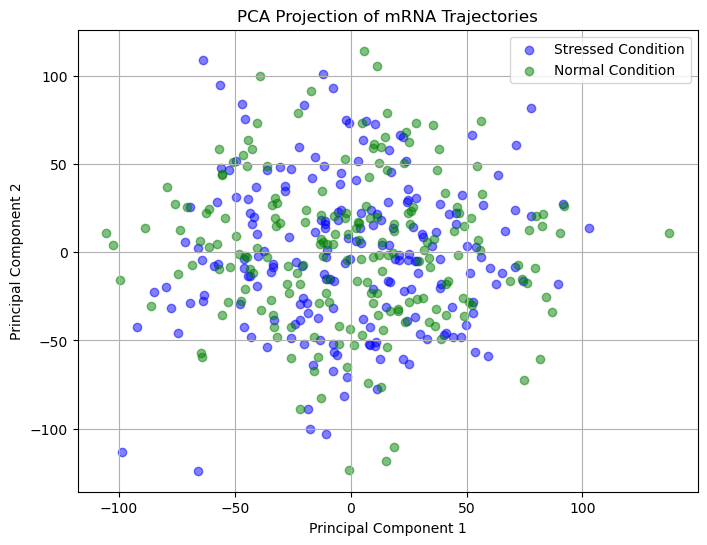

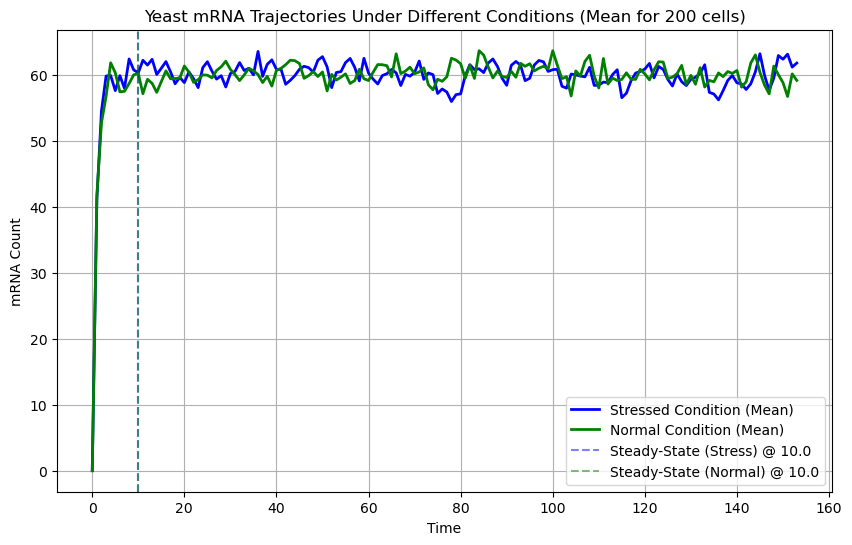

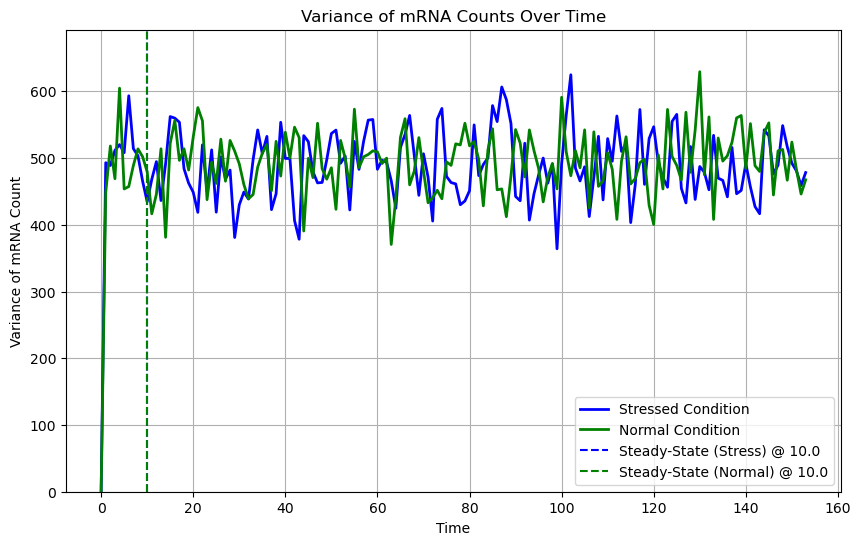


=== Variance at Steady State ===
  Stressed Condition (after 10.0 min): Mean = 60.06, Variance = 491.06
  Normal Condition (after 10.0 min): Mean = 60.13, Variance = 495.21


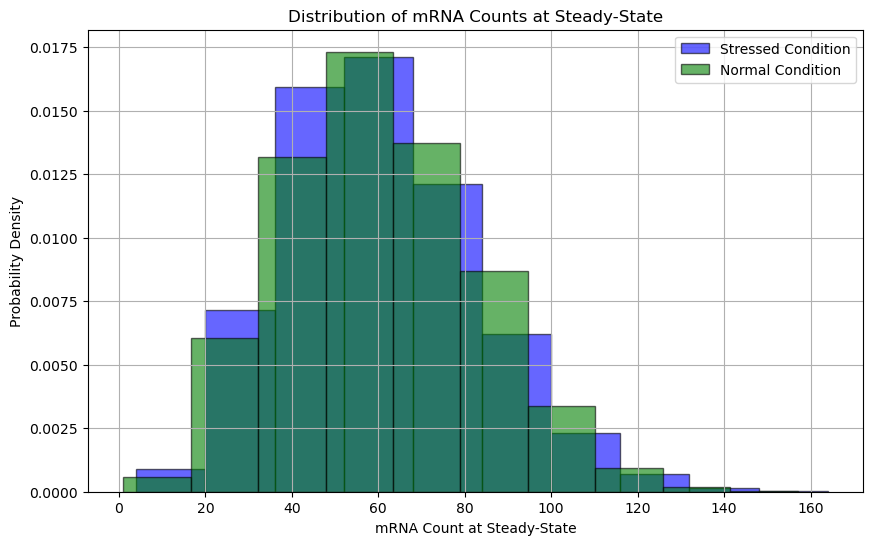

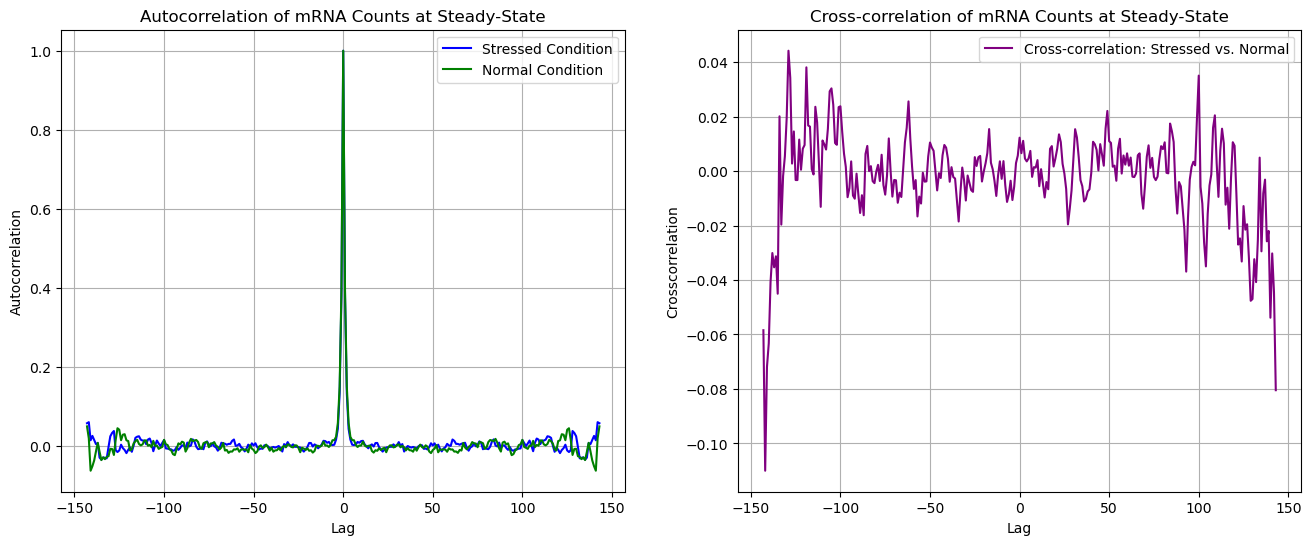

In [8]:
# Set up simulation parameters 
# get the min degradation rate
min_d = min([param_set['d'] for param_set in parameter_sets])    
# get the time point after which the system reaches steady state 
steady_state_time = int(10 / min_d)

# !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
# 144 time points: to match experimental conditions, where typically a photo is taken every 5 min over 12 hours --> 144 time points
# extend time points to account for steady state
extended_time_points = np.arange(time_points[0], 
                                 len(time_points) + steady_state_time, 
                                 time_points[1] - time_points[0])

size = 200  # size of the simulation needs to be big enough for this particular system to reach steady state

# Run the simulation function
df_results = simulate_two_telegraph_model_systems(parameter_sets, extended_time_points, size)

# Save dataset for ML classification
output_file = f"data/mRNA_trajectories_var_mean_fixed_{variance_target}_{mu_target}.csv"
df_results.to_csv(output_file, index=False)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# report the mean and variance of the mRNA counts at steady state
report =  statistical_report(parameter_sets, stress_trajectories, normal_trajectories)
X_train, X_test, y_train, y_test = load_and_split_data(output_file)
svm_accuracy = svm_classifier(X_train, X_test, y_train, y_test)
rf_accuracy = random_forest_classifier(X_train, X_test, y_train, y_test)
log_reg_accuracy = logistic_regression_classifier(X_train, X_test, y_train, y_test)
random_accuracy = random_classifier(y_test)
pca_plot(output_file)

# Plots
plot_mRNA_trajectory(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_variance(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_dist(parameter_sets, stress_trajectories, normal_trajectories)
plot_autocrosscorr(parameter_sets, stress_trajectories, normal_trajectories)

If we want to change the variance over a range of variance ratio:

Running Variance Ratio Simulations:   0%|          | 0/290 [00:00<?, ?it/s]

Positive solution found with different initial guesses.
Solution for stress condition: [228.07926747   0.82538795]
Solution: [228.07926747   0.82538795], Solved equation: [6.87805368215777e-12, 1.5000978237367235e-10]


/tmp/ipykernel_1654304/2750162325.py:64: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(equations, initial_guess, args=(param_set['sigma_u'], param_set['sigma_b'], param_set['d'], mu_target, var_for_condition))


Positive solution found with different initial guesses.
Solution for normal condition: [1.20893294e+03 7.50667504e-02]
Solution: [1.20893294e+03 7.50667504e-02], Solved equation: [-8.363087999896379e-12, -2.0365860109450296e-09]
Updated Parameter Sets: [{'sigma_u': 18.0, 'sigma_b': 0.8253879522097174, 'rho': 228.07926747444753, 'd': 1.0, 'label': 0}, {'sigma_u': 9.0, 'sigma_b': 0.07506675039929178, 'rho': 1208.9329432964666, 'd': 1.0, 'label': 1}]


Running simulations on 12 cores...
System 1 parameters: {'sigma_u': 18.0, 'sigma_b': 0.8253879522097174, 'rho': 228.07926747444753, 'd': 1.0, 'label': 0}


Running simulations on 12 cores...
System 2 parameters: {'sigma_u': 9.0, 'sigma_b': 0.07506675039929178, 'rho': 1208.9329432964666, 'd': 1.0, 'label': 1}


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:15<00:00,  7.70s/it]



=== Statistical Report ===

📊 **Steady-State Statistics:**
  Stressed Condition (after 10.0 min):
    - Mean mRNA Count: 10.15
    - Variance: 124.96

  Normal Condition (after 10.0 min):
    - Mean mRNA Count: 10.13
    - Variance: 1235.24


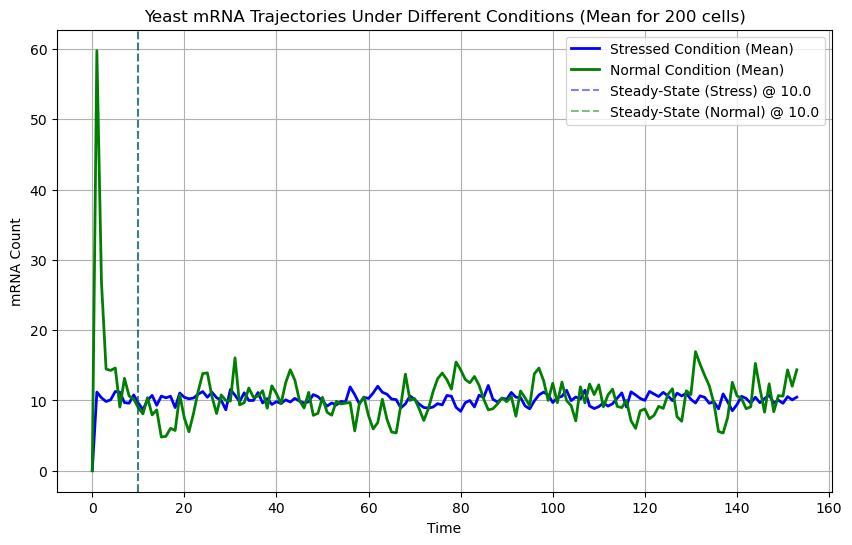

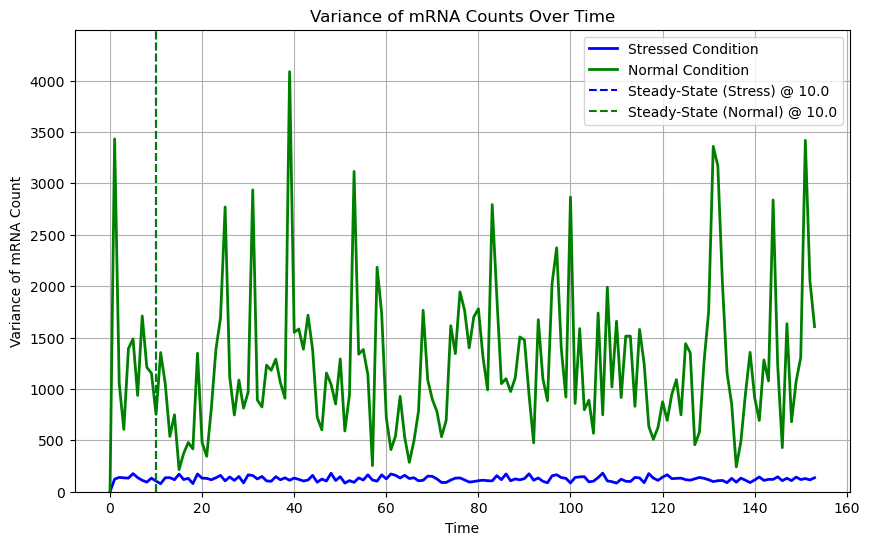

Running Variance Ratio Simulations:   0%|          | 1/290 [00:16<1:20:47, 16.77s/it]


=== Variance at Steady State ===
  Stressed Condition (after 10.0 min): Mean = 10.15, Variance = 124.96
  Normal Condition (after 10.0 min): Mean = 10.13, Variance = 1235.24
Positive solution found with different initial guesses.
Solution for stress condition: [250.91523907   0.74715074]
Solution: [250.91523907   0.74715074], Solved equation: [-1.2398970739013748e-12, -3.441869012021925e-11]


Running Variance Ratio Simulations:   0%|          | 1/290 [00:17<1:24:15, 17.49s/it]


KeyboardInterrupt: 

In [3]:
###############################################################################
# 1) Symbolic definitions for mean & variance
###############################################################################
rho, mu, sigma_sq, d, sigma_u, sigma_b = sp.symbols(
    'rho mu sigma_sq d sigma_u sigma_b', real=True, positive=True
)
init_printing(use_unicode=True)

# Define the variance and mean equations
def equations(vars, sigma_u, sigma_b, d, mu_target, variance_target):
    rho = vars[0]
    sigma_b = vars[1]

    # Mean equation
    mean_eqn = sigma_b * rho / (d * (sigma_b + sigma_u))

    # Variance equation
    variance_eqn = (sigma_b * rho / (d * (sigma_b + sigma_u))) + \
                     ((sigma_u * sigma_b) * rho**2 / (d * (sigma_b + sigma_u + d) * (sigma_u + sigma_b)**2))

    # Define the equations to be solved
    eq1 = mean_eqn - mu_target
    eq2 = variance_eqn - variance_target

    return [eq1, eq2]

###############################################################################
# 2) Define parameters
###############################################################################
variance_target_normal = 1200.0  # Fixed normal variance
mu_target = 10.0                 # Mean (same for both)
variance_ratios = np.arange(0.1, 3.0, 0.01)

parameters = {
    "stress": {"sigma_u": 18.0, "sigma_b": 0.01, "d": 1.0},
    "normal": {"sigma_u": 9.0,  "sigma_b": 0.02, "d": 1.0}
}


###############################################################################
# 3) Loop over different variance ratios
###############################################################################
for ratio in tqdm.tqdm(variance_ratios, desc="Running Variance Ratio Simulations"):
    # For the stress condition, we define variance_target_stress by ratio
    variance_target_stress = ratio * variance_target_normal
    # Store positive rho values for both conditions
    rho_values = {}
    sigma_b_values = {}

    for condition, param_set in parameters.items():
        # Decide which variance to use for this condition
        if condition == "normal":
            var_for_condition = variance_target_normal
        else:  # condition == "stress"
            var_for_condition = variance_target_stress
    

        # Initial guess for rho and sigma_b, this is important to finding a solution that satisfies the equations
        rho_ig = np.arange(1, 10000, 10)
        sigma_b_ig = np.arange(1, 10000, 10)
        initial_guesses = [[rho, sigma_b] for rho in rho_ig for sigma_b in sigma_b_ig]

        for initial_guess in initial_guesses:
            solution = fsolve(equations, initial_guess, args=(param_set['sigma_u'], param_set['sigma_b'], param_set['d'], mu_target, var_for_condition))
            solved_equations = equations(solution, param_set['sigma_u'], param_set['sigma_b'], param_set['d'], mu_target, var_for_condition)

            # Check if the solved equation is close to zero
            if -1e-6 < solved_equations[0] < 1e-6 and -1e-6 < solved_equations[1] < 1e-6:
                # Check if the solution is positive
                if solution[0] > 0 and solution[1] > 0:
                    print('Positive solution found with different initial guesses.')
                    print(f"Solution for {condition} condition: {solution}")
                    rho_values[condition] = solution[0]
                    sigma_b_values[condition] = solution[1]
                    #DEBUG
                    print(f'Solution: {solution}, Solved equation: {solved_equations}')

                    break

    # Updated Parameter Sets using the calculated rho values
    parameter_sets = [
        {"sigma_u": parameters["stress"]["sigma_u"],
        "sigma_b": sigma_b_values["stress"],
        "rho": rho_values["stress"],
        "d": parameters["stress"]["d"],
        "label": 0},

        {"sigma_u": parameters["normal"]["sigma_u"],
        "sigma_b": sigma_b_values["normal"],
        "rho": rho_values["normal"],
        "d": parameters["normal"]["d"],
        "label": 1}
    ]
    # Output the results
    # print("Calculated rho values:", rho_values)
    # print("Calculated sigma_b values:", sigma_b_values)
    print("Updated Parameter Sets:", parameter_sets)

    # Set up simulation parameters 
    # get the min degradation rate
    min_d = min([param_set['d'] for param_set in parameter_sets])    
    # get the time point after which the system reaches steady state 
    steady_state_time = int(10 / min_d)

    # !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
    time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
    # 144 time points: to match experimental conditions, where typically a photo is taken every 5 min over 12 hours --> 144 time points
    # extend time points to account for steady state
    extended_time_points = np.arange(time_points[0], 
                                    len(time_points) + steady_state_time, 
                                    time_points[1] - time_points[0])

    size = 200  # size of the simulation needs to be big enough for this particular system to reach steady state

    # Run the simulation function
    df_results = simulate_two_telegraph_model_systems(parameter_sets, extended_time_points, size)

    # Save dataset for ML classification
    output_file = f"data/mRNA_trajectories_var_mean_fixed_{var_for_condition}_{mu_target}.csv"
    df_results.to_csv(output_file, index=False)

    # Extract mRNA trajectories for each condition
    stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
    normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

    # report the mean and variance of the mRNA counts at steady state
    report =  statistical_report(parameter_sets, stress_trajectories, normal_trajectories)
    plot_mRNA_trajectory(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
    plot_mRNA_variance(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)